In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# DGP for regression

Here we'll show the DGP for regression, using small to medium data sets. 

In [2]:
%pip list | grep gpflow

gpflow                             2.0.4
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip list | grep tensorflow

tensorflow                         2.2.0
tensorflow-estimator               2.2.0
tensorflow-probability             0.10.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip list | grep scipy

scipy                              1.4.1
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(0)

import time

import matplotlib.pyplot as plt
%matplotlib inline 

import gpflow
from gpflow.likelihoods import Gaussian
from gpflow.kernels import RBF, White
from gpflow.mean_functions import Constant
#from gpflow.models.sgpr import SGPR, GPRFITC
#from gpflow.models.svgp import SVGP
from gpflow.models.gpr import GPR
#from gpflow.training import AdamOptimizer, ScipyOptimizer, NatGradOptimizer
#import gpflow.optimizers.NatGradOptimizer as NatGradOptimizer



#from gpflow.actions import Action, Loop

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp

import sys
#sys.path.append('/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master')

from doubly_stochastic_dgp.dgp import DGP
from datasets import Datasets
datasets = Datasets(data_path='/Users/luck1226/Py/ML/Doubly-Stochastic-DGP-master/data/')
#datasets = Datasets(data_path='/Users/luck1226/Py/CoDaS/deepGP')

ModuleNotFoundError: No module named 'gpflow.params'

Let's use the kin8nm data set

In [35]:
#data = datasets.all_datasets['kin8nm'].get_data()
#data = datasets.all_datasets['boston'].get_data()
#X, Y, Xs, Ys, Y_std = [data[_] for _ in ['X', 'Y', 'Xs', 'Ys', 'Y_std']]
#print('N: {}, D: {}, Ns: {}'.format(X.shape[0], X.shape[1], Xs.shape[0]))

N: 7372, D: 8, Ns: 820


In [43]:
import pandas as pd
df = pd.read_csv('Boston.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [44]:
from sklearn.datasets import load_boston
X_b, y_b = load_boston(return_X_y=True)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2)

In [46]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [47]:
X = X_train
Y = y_train
Xs = X_test
Ys = y_test
Y_std = 1.

## Single layer models

Our baseline model is a sparse GP, but since the dataset is small we can also train without minibatches so we'll also compare to a collapsed sparse GP (with analytically optimal $q(\mathbf u)$) which is known as SGPR in GPflow terminology, and we'll also cpmpare to FITC

In [48]:
def make_single_layer_models(X, Y, Z):
    D = X.shape[1]
    m_sgpr = SGPR(X, Y, RBF(D), Z.copy())
    m_svgp = SVGP(X, Y, RBF(D), Gaussian(), Z.copy())
    m_fitc = GPRFITC(X, Y, RBF(D), Z.copy())
    for m in m_sgpr, m_svgp, m_fitc:
        m.likelihood.variance = 0.01
    return [m_sgpr, m_svgp, m_fitc], ['{} {}'.format(n, len(Z)) for n in ['SGPR', 'SVGP', 'FITC']]

Z_100 = kmeans2(X, 100, minit='points')[0]
models_single_layer, names_single_layer = make_single_layer_models(X, Y, Z_100)


## DGP models

We'll include a DGP with a single layer here for comparision. We've used a largish minibatch size of $\text{min}(1000, N)$, but it works fine for smaller batches too

In the paper we used 1 sample. Here we'll go up to 5 in celebration of the new implementation (which is much more efficient)

In [49]:
def make_dgp_models(X, Y, Z):
    models, names = [], []
    for L in range(1, 4):
        D = X.shape[1]

        # the layer shapes are defined by the kernel dims, so here all hidden layers are D dimensional 
        kernels = []
        for l in range(L):
            kernels.append(RBF(D))

        # between layer noise (doesn't actually make much difference but we include it anyway)
        for kernel in kernels[:-1]:
            kernel += White(D, variance=1e-5) 

        mb = 1000 if X.shape[0] > 1000 else None 
        model = DGP(X, Y, Z, kernels, Gaussian(), num_samples=5, minibatch_size=mb)

        # start the inner layers almost deterministically 
        for layer in model.layers[:-1]:
            layer.q_sqrt = layer.q_sqrt.value * 1e-5

        models.append(model)
        names.append('DGP{} {}'.format(L, len(Z)))
    
    return models, names

models_dgp, names_dgp = make_dgp_models(X, Y, Z_100)


13 13
13 13
13 13


## Prediction

We'll calculate test rmse and likelihood in batches (so the larger datasets don't cause memory problems)

For the DGP models we need to take an average over the samples for the rmse. The `predict_density` function already does this internally


In [50]:
def batch_assess(model, assess_model, X, Y):
    n_batches = max(int(X.shape[0]/1000.), 1)
    lik, sq_diff = [], []
    for X_batch, Y_batch in zip(np.array_split(X, n_batches), np.array_split(Y, n_batches)):
        l, sq = assess_model(model, X_batch, Y_batch)
        lik.append(l)
        sq_diff.append(sq)
    lik = np.concatenate(lik, 0)
    sq_diff = np.array(np.concatenate(sq_diff, 0), dtype=float)
    return np.average(lik), np.average(sq_diff)**0.5

def assess_single_layer(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch)
    lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5),  1)
    sq_diff = Y_std**2*((m - Y_batch)**2)
    return lik, sq_diff 

S = 100
def assess_sampled(model, X_batch, Y_batch):
    m, v = model.predict_y(X_batch, S)
    S_lik = np.sum(norm.logpdf(Y_batch*Y_std, loc=m*Y_std, scale=Y_std*v**0.5), 2)
    lik = logsumexp(S_lik, 0, b=1/float(S))
    
    mean = np.average(m, 0)
    sq_diff = Y_std**2*((mean - Y_batch)**2)
    return lik, sq_diff

## Training 

We'll optimize single layer models and using LFBGS and the dgp models with Adam. It will be interesting to compare the result of `m_svgp` compared to `m_dgp1`: if there is a difference it will be down to the optimizer. 

We'll show here also the reuslt of using a small and large number of iterations.

In [51]:
iterations_few = 100
iterations_many = 500
s = '{:<16}  lik: {:.4f}, rmse: {:.4f}'

In [52]:
for iterations in [iterations_few, iterations_many]:
    print('after {} iterations'.format(iterations))
    for m, name in zip(models_single_layer, names_single_layer):
        ScipyOptimizer().minimize(m, maxiter=iterations)
        lik, rmse = batch_assess(m, assess_single_layer, Xs, Ys)
        print(s.format(name, lik, rmse))

after 100 iterations
SGPR 100          lik: -5.4976, rmse: 23.3580
SVGP 100          lik: -4.5724, rmse: 23.3580
FITC 100          lik: -2.7732, rmse: 4.5233
after 500 iterations
SGPR 100          lik: -5.4976, rmse: 23.3580
SVGP 100          lik: -4.5724, rmse: 23.3580
FITC 100          lik: -2.8494, rmse: 4.4722


Now for the DGP models. First we use Adam for all parameters (as in the Doubly Stochastic VI for DGPs paper)

In [53]:
for iterations in [iterations_few, iterations_many]:
    print('after {} iterations'.format(iterations))
    for m, name in zip(models_dgp, names_dgp):
        AdamOptimizer(0.01).minimize(m, maxiter=iterations)
        lik, rmse = batch_assess(m, assess_sampled, Xs, Ys)
        print(s.format(name, lik, rmse))

after 100 iterations
DGP1 100          lik: -124.2017, rmse: 23.3404
DGP2 100          lik: -125.0708, rmse: 23.3469
DGP3 100          lik: -125.6772, rmse: 23.3531
after 500 iterations
DGP1 100          lik: -25.4344, rmse: 20.7354
DGP2 100          lik: -26.4687, rmse: 20.7502
DGP3 100          lik: -26.9734, rmse: 20.6902


We can also use natural gradients for the final layer, which can help considerably. 

In [54]:
for iterations in [iterations_few, iterations_many]:
    print('after {} iterations'.format(iterations))
    for m, name in zip(models_dgp, names_dgp):
        ng_vars = [[m.layers[-1].q_mu, m.layers[-1].q_sqrt]]
        for v in ng_vars[0]:
            v.set_trainable(False)    
        ng_action = NatGradOptimizer(gamma=0.1).make_optimize_action(m, var_list=ng_vars)
        adam_action = AdamOptimizer(0.01).make_optimize_action(m)

        Loop([ng_action, adam_action], stop=iterations)()

        lik, rmse = batch_assess(m, assess_sampled, Xs, Ys)
        print(s.format(name, lik, rmse))

after 100 iterations
DGP1 100          lik: -11.4723, rmse: 14.6248
DGP2 100          lik: -11.7904, rmse: 14.5770
DGP3 100          lik: -11.9259, rmse: 14.5059
after 500 iterations
DGP1 100          lik: -5.8425, rmse: 11.0458
DGP2 100          lik: -5.9167, rmse: 11.0394
DGP3 100          lik: -5.9616, rmse: 11.0120


Note that even after 100 iterations we get a good result, which is not the case using ordinary gradients.

In [70]:
mm, vv = models_single_layer[2].predict_y(X_test)

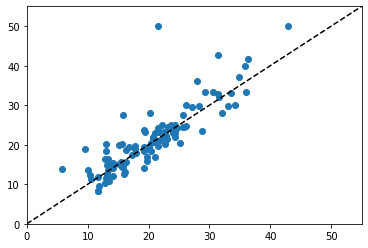

In [73]:
plt.scatter(mm,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

In [77]:
mm1, vv1 = models_dgp[2].predict_y(Xs)

InvalidArgumentError: You must feed a value for placeholder tensor 'autoflow/DGP/predict_y_8/Placeholder_1' with dtype int32
	 [[Node: autoflow/DGP/predict_y_8/Placeholder_1 = Placeholder[dtype=DT_INT32, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'autoflow/DGP/predict_y_8/Placeholder_1', defined at:
  File "/Users/luck1226/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/luck1226/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/luck1226/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/luck1226/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/luck1226/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-545387588c9a>", line 5, in <module>
    lik, rmse = batch_assess(m, assess_sampled, Xs, Ys)
  File "<ipython-input-50-1d7570c4067f>", line 5, in batch_assess
    l, sq = assess_model(model, X_batch, Y_batch)
  File "<ipython-input-50-1d7570c4067f>", line 20, in assess_sampled
    m, v = model.predict_y(X_batch, S)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/gpflow/decors.py", line 164, in autoflow_wrapper
    _setup_storage(store, *af_args, **af_kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/gpflow/decors.py", line 187, in _setup_storage
    store['arguments'] = [tf.placeholder(*arg) for arg in args]
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/gpflow/decors.py", line 187, in <listcomp>
    store['arguments'] = [tf.placeholder(*arg) for arg in args]
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/luck1226/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'autoflow/DGP/predict_y_8/Placeholder_1' with dtype int32
	 [[Node: autoflow/DGP/predict_y_8/Placeholder_1 = Placeholder[dtype=DT_INT32, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
